### Races with equal number 87 (using the smallest class size to ensure balance)

In [2]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN
df_cleaned = df.dropna(subset=['Patient Race'])

In [5]:
# Group by 'Subject ID' to handle multiple images per patient
grouped = df_cleaned.groupby('Subject ID')

# Randomly select one image per patient
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Label mapping for converting race categories to integers
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Convert the 'Patient Race' to integer labels
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

In [6]:
num_patients = df_single_image_per_patient['Subject ID'].nunique()
num_images = len(df_single_image_per_patient)

# Print the results
print(f"Number of unique patients: {num_patients}")
print(f"Number of images after selecting one per patient: {num_images}")

Number of unique patients: 25826
Number of images after selecting one per patient: 25826


Class distribution after cleaning:
White                                        23969
Black or African-American                     1135
Asian                                          547
American Indian or Alaskan Native               88
Native Hawaiian or Other Pacific Islander       87
Name: Patient Race, dtype: int64


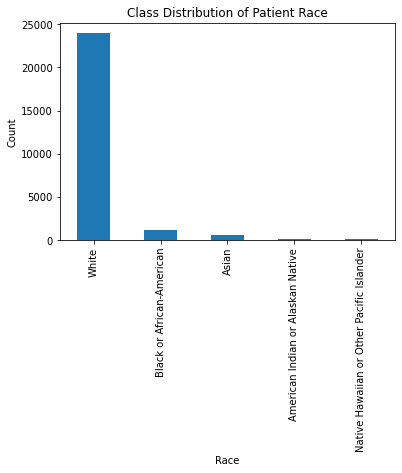

In [7]:
import matplotlib.pyplot as plt
# Check class distribution
print("Class distribution after cleaning:")
print(df_single_image_per_patient['Patient Race'].value_counts())

# Plot class distribution
df_single_image_per_patient['Patient Race'].value_counts().plot(kind='bar', title="Class Distribution of Patient Race", xlabel="Race", ylabel="Count")
plt.show()

In [8]:
# Define the number of samples for each class (using the smallest class size to ensure balance)
min_class_size = min(df_single_image_per_patient['Patient Race'].value_counts())

# Resample each race to have an equal number of instances
df_balanced = df_single_image_per_patient.groupby('Patient Race', group_keys=False).apply(
    lambda x: x.sample(min_class_size, random_state=42))

# Check the class distribution after resampling
print("Class distribution after resampling:")
print(df_balanced['Patient Race'].value_counts())

Class distribution after resampling:
White                                        87
Native Hawaiian or Other Pacific Islander    87
Black or African-American                    87
Asian                                        87
American Indian or Alaskan Native            87
Name: Patient Race, dtype: int64


In [9]:
print("Shape of the cleaned DataFrame:", df_balanced.shape)

Shape of the cleaned DataFrame: (435, 21)


In [10]:
# Split the data into training and validation sets (stratified by race)
X_train, X_val, y_train, y_val = train_test_split(
    df_balanced['File Location'],  # File paths to the DICOM images
    df_balanced['Race_Label'],     # Race labels as integers
    test_size=0.2, 
    stratify=df_balanced['Patient Race'], 
    random_state=42
)

In [11]:
current_path = os.getcwd()
print(current_path)

u:\GitHub\AI-ethnicity-med-image


In [12]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [13]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((224, 224))  # Resize to 224x224 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [14]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

# Now, check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

# Print the correct number of images and labels
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of training images: 348
Number of validation images: 87
Number of training labels: 348
Number of validation labels: 87


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [16]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
num_classes = 5
output = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

In [17]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=10, 
                    batch_size=32)

# Save the model
model.save('ethnicity_classification_model.h5')

Epoch 1/10
11/11 [==============================] - 23s 2s/step - loss: 1.7695 - accuracy: 0.2902 - val_loss: 1.3471 - val_accuracy: 0.3678
Epoch 2/10
11/11 [==============================] - 17s 2s/step - loss: 1.5653 - accuracy: 0.2989 - val_loss: 1.2878 - val_accuracy: 0.4023
Epoch 3/10
11/11 [==============================] - 18s 2s/step - loss: 1.5588 - accuracy: 0.3132 - val_loss: 1.3001 - val_accuracy: 0.3793
Epoch 4/10
11/11 [==============================] - 19s 2s/step - loss: 1.4980 - accuracy: 0.3247 - val_loss: 1.3058 - val_accuracy: 0.4023
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 1.4589 - accuracy: 0.3448 - val_loss: 1.3264 - val_accuracy: 0.3563
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 1.4451 - accuracy: 0.3190 - val_loss: 1.3051 - val_accuracy: 0.3448
Epoch 7/10
11/11 [==============================] - 18s 2s/step - loss: 1.4573 - accuracy: 0.3362 - val_loss: 1.2848 - val_accuracy: 0.3793
Epoch 8/10
11/11 [==

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

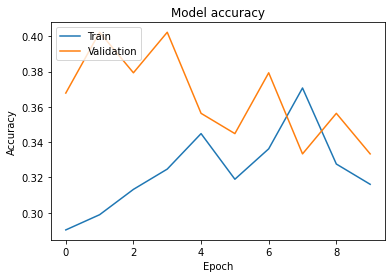

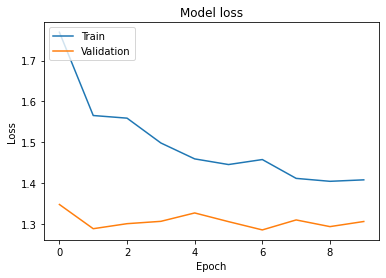

In [19]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

Accuracy: 0.3333


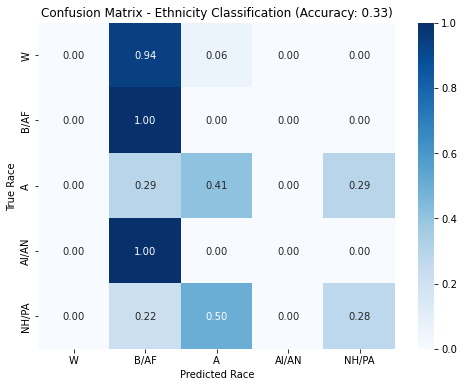

In [21]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cma, annot=True, fmt='.2f', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()

In [22]:
# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_mapping.keys(), zero_division=1))

Classification Report:
                                           precision    recall  f1-score   support

                                    White       1.00      0.00      0.00        17
                Black or African-American       0.28      1.00      0.44        17
                                    Asian       0.41      0.41      0.41        17
        American Indian or Alaskan Native       1.00      0.00      0.00        18
Native Hawaiian or Other Pacific Islander       0.50      0.28      0.36        18

                                 accuracy                           0.33        87
                                macro avg       0.64      0.34      0.24        87
                             weighted avg       0.64      0.33      0.24        87

